In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns

import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # а также другие алгоритмы
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

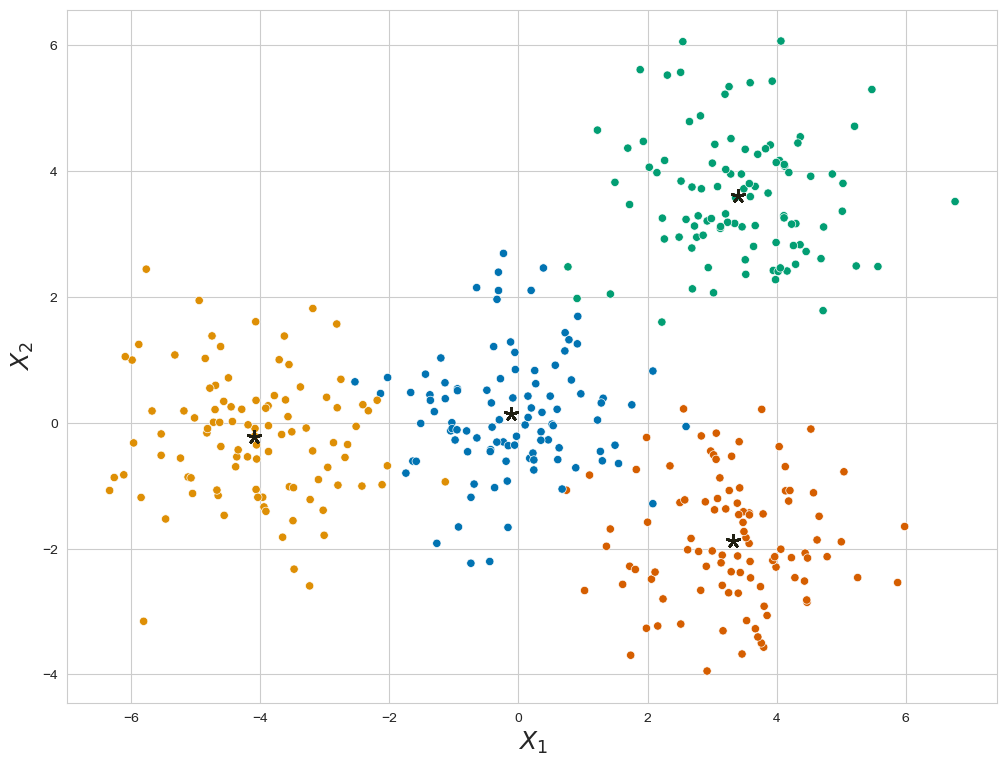

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                # dists.append(self._calculate_distance(X, centroid))
                dist = self._calculate_distance(X, centroid)[:, np.newaxis]  # This adds the new axis
                dists.append(dist)
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        distances = np.array([self._calculate_distance(X, centroid) for centroid in self.centroids])
        cluster_labels = np.argmin(distances, axis=0)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.sqrt(np.sum((X - centroid) ** 2, axis=1))

        return dist
    
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

In [7]:
kmeans = MyKMeans(n_clusters=4, visualize=True)

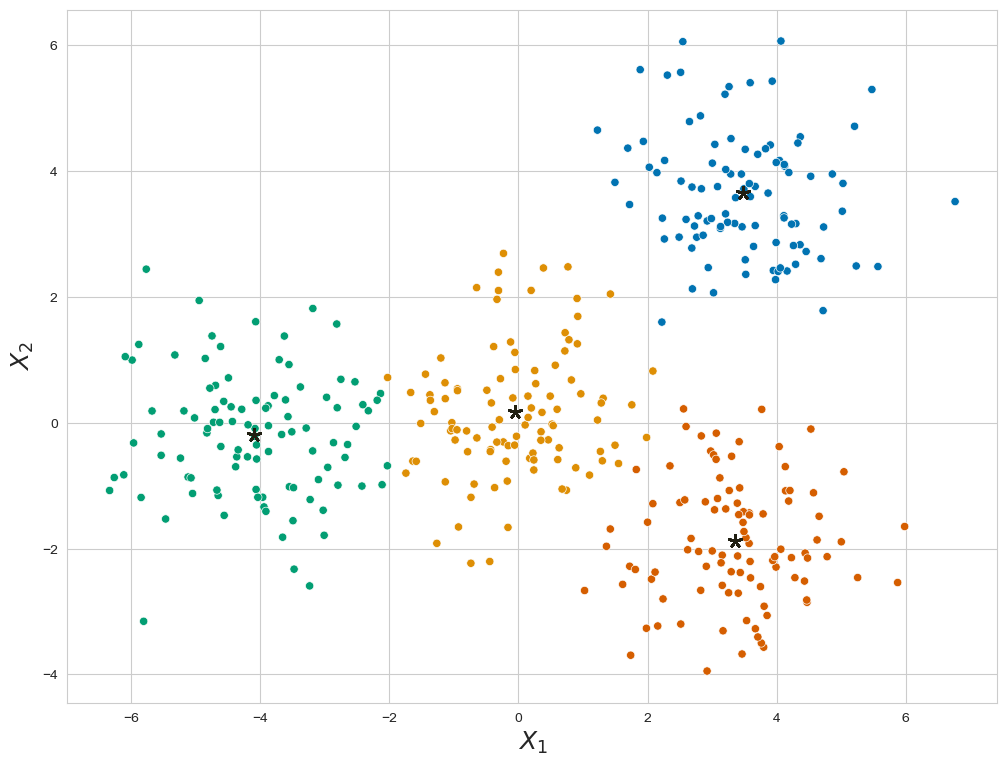

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
kmeans.fit(X)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target

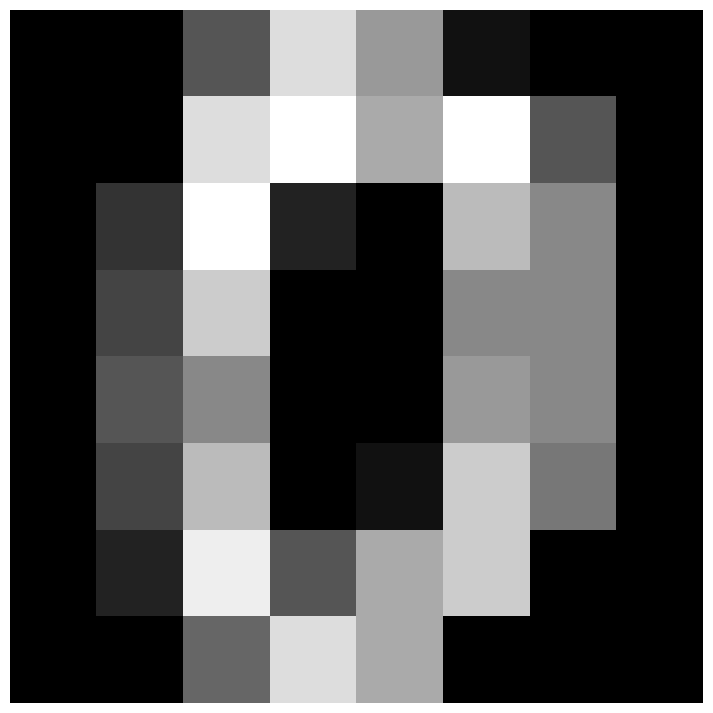

In [10]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score

In [12]:
def algorithm_selection(X, true_labels, 
                        distances=['euclidean', 'manhattan', 'cosine', 'l1', 'l2'], 
                        algorithms=['average', 'single', 'complete'], 
                        metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации - фиксировано 4
    :return compare_dataframe: таблица с метриками кластеризации
    """

    results = []

    for dist in distances:
        for linkage in algorithms:
            clustering = AgglomerativeClustering(n_clusters=len(np.unique(true_labels)), metric=dist, linkage=linkage)
            labels = clustering.fit_predict(X)

            homogeneity = homogeneity_score(true_labels, labels)
            completeness = completeness_score(true_labels, labels)
            v_measure = v_measure_score(true_labels, labels)
            silhouette = silhouette_score(X, labels, metric=dist)

            results.append({
                'distance': dist,
                'linkage': linkage,
                'homogeneity': homogeneity,
                'completeness': completeness,
                'v_measure': v_measure,
                'silhouette': silhouette
            })

    compare_dataframe = pd.DataFrame(results)
    
    return compare_dataframe

In [13]:
algorithm_selection(X, y, distances=['euclidean', 'manhattan', 'cosine', 'l1', 'l2'], 
                        algorithms=['average', 'single', 'complete'])

distance   linkage  homogeneity  completeness  v_measure  silhouette
0   euclidean   average     0.655393      0.782342   0.713263    0.146625
1   euclidean    single     0.005056      0.273755   0.009929   -0.133621
2   euclidean  complete     0.590549      0.637772   0.613253    0.119271
3   manhattan   average     0.566751      0.778942   0.656117    0.105238
4   manhattan    single     0.005102      0.276237   0.010019   -0.203816
5   manhattan  complete     0.646372      0.686109   0.665648    0.160617
6      cosine   average     0.648268      0.808762   0.719676    0.218229
7      cosine    single     0.005050      0.273389   0.009916   -0.281789
8      cosine  complete     0.528727      0.577415   0.551999    0.144179
9          l1   average     0.566751      0.778942   0.656117    0.105238
10         l1    single     0.005102      0.276237   0.010019   -0.203816
11         l1  complete     0.646372      0.686109   0.665648    0.160617
12         l2   average     0.655393      0.782342   0.713263    0.146625
13         l2    single     0.005056      0.273755   0.009929   -0.133621
14         l2  complete     0.590549      0.637772   0.613253    0.119271

Мысли: single везде дает худшие результаты. По всему остальным метрикам, кроме silhouette, результаты похоже (чем ближе к 1, тем лучше). Основываясь на silhouette, лучше всего отработал cosine	average.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [14]:
fc_data = pd.read_csv(join('../data/raw_data', "flow_c_data.csv"), index_col=0)
fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c  
0    -1.406912  0.384406  
1     6.034845  0.577039  
2    -0.318668 -0.493832  
3     0.694883  3.416960  
4     5.563345  0.471591  
...        ...       ...  
9995 -0.591343  2.857737  
9996  0.344169 -0.626795  
9997 -0.887078  4.369294  
9998 -0.112999  0.069239  
9999 -0.441455  0.378331  

[10000 rows x 9 columns]

##### YOUR TURN TO CODE:

In [15]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [16]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [17]:
for col in fc_data.columns:
    print(f'NAs in {col}: {fc_data[col].isna().sum()}')

NAs in FSC-A: 0
NAs in SSC-A: 0
NAs in HLA-DR: 0
NAs in CD3: 0
NAs in CD45: 0
NAs in CD14: 0
NAs in CD56: 0
NAs in CD19: 0
NAs in CD11c: 0


In [18]:
for col in fc_data.columns:
    print(f'Unique values in {col}: {fc_data[col].unique().shape[0]}')

Unique values in FSC-A: 9968
Unique values in SSC-A: 9819
Unique values in HLA-DR: 10000
Unique values in CD3: 10000
Unique values in CD45: 10000
Unique values in CD14: 10000
Unique values in CD56: 10000
Unique values in CD19: 10000
Unique values in CD11c: 10000


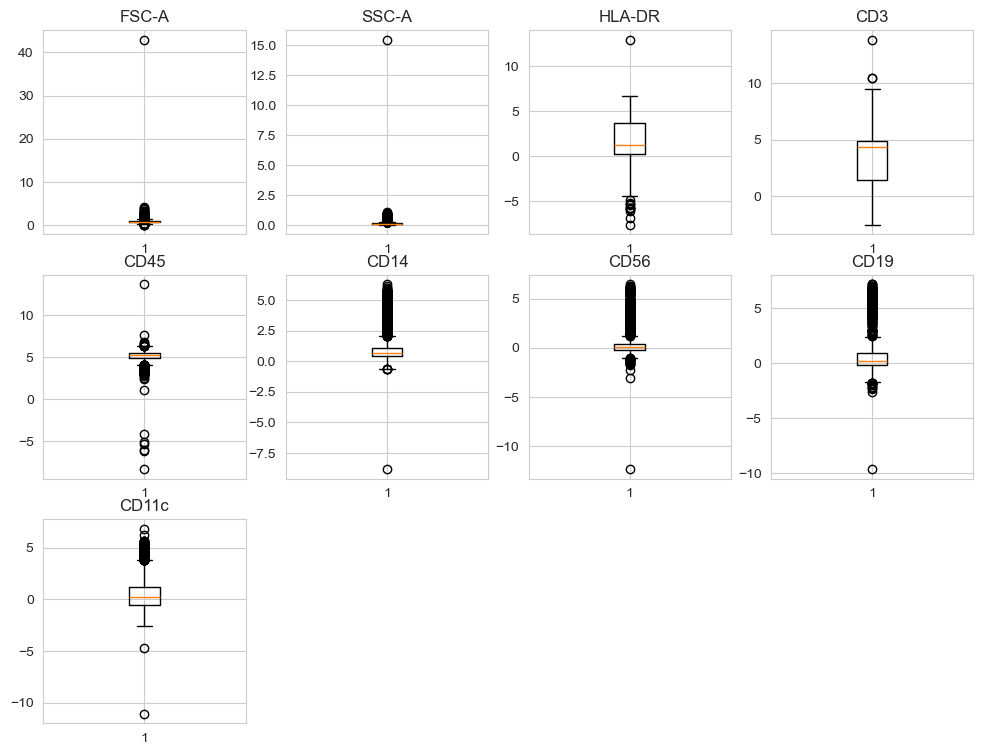

In [19]:
for i, col in enumerate(fc_data.columns):
    plt.subplot(3, 4, i+1)
    plt.boxplot(fc_data[col])
    plt.title(col)
plt.show()

Уберем самые заметные выбросы:

In [20]:
def remove_outliers(df, n):
    for col in df.columns:
        sorted_values = df[col].sort_values()
        outliers = sorted_values[:n].index.union(sorted_values[-n:].index)
        df = df.drop(outliers)
    return df

fc_data_filtered = remove_outliers(fc_data, 2)
fc_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9964 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   9964 non-null   float64
 1   SSC-A   9964 non-null   float64
 2   HLA-DR  9964 non-null   float64
 3   CD3     9964 non-null   float64
 4   CD45    9964 non-null   float64
 5   CD14    9964 non-null   float64
 6   CD56    9964 non-null   float64
 7   CD19    9964 non-null   float64
 8   CD11c   9964 non-null   float64
dtypes: float64(9)
memory usage: 778.4 KB


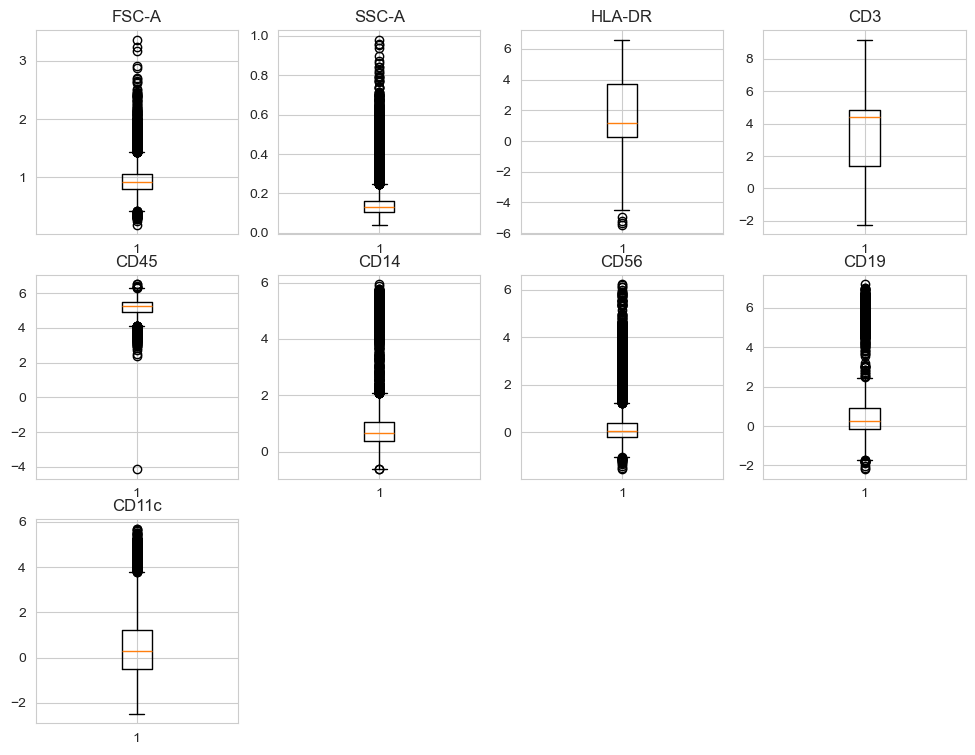

In [21]:
for i, col in enumerate(fc_data_filtered.columns):
    plt.subplot(3, 4, i+1)
    plt.boxplot(fc_data_filtered[col])
    plt.title(col)
plt.show()

Посмотрим на распределения:

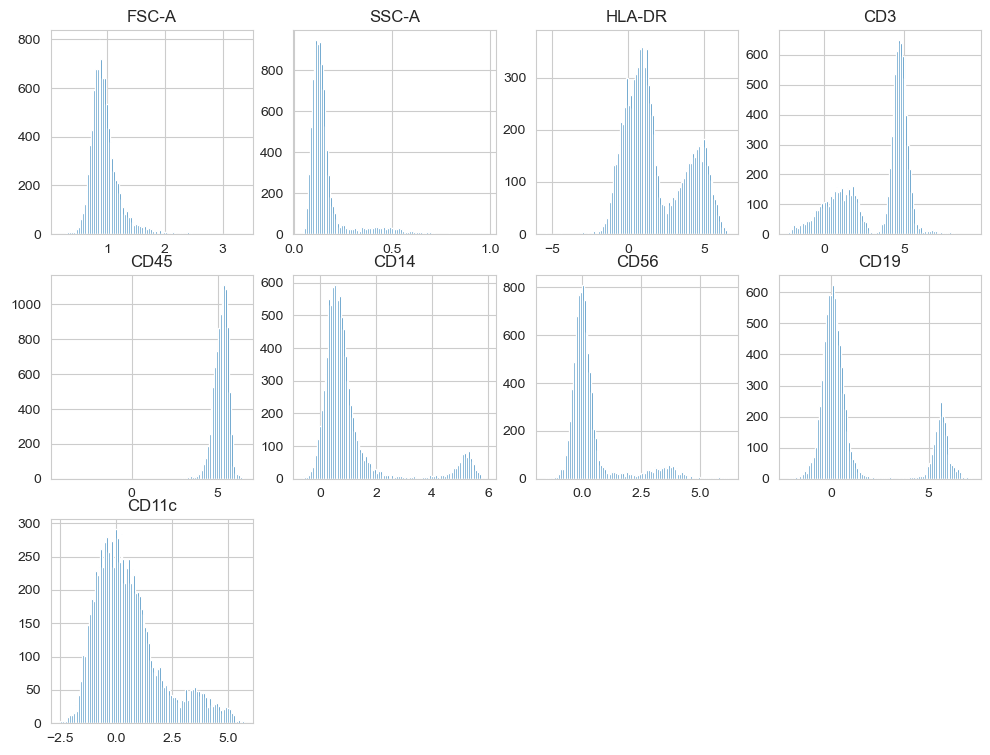

In [22]:
for i, col in enumerate(fc_data_filtered.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(fc_data_filtered[col], bins=100)
    plt.title(col)
plt.show()

CD3 - T-cells, CD19 - B-cells, CD14 - monocytes, CD56 - NK-cells, CD11c - dendritic cells. CD45 - all leukocytes.
Получается, из них HLA-DR будет эскпрессироваться на дендритных, моноцитах и B-клетках в основном.
Собственно признаков у нас - 7, а классов скорее всего 5.

<Axes: >

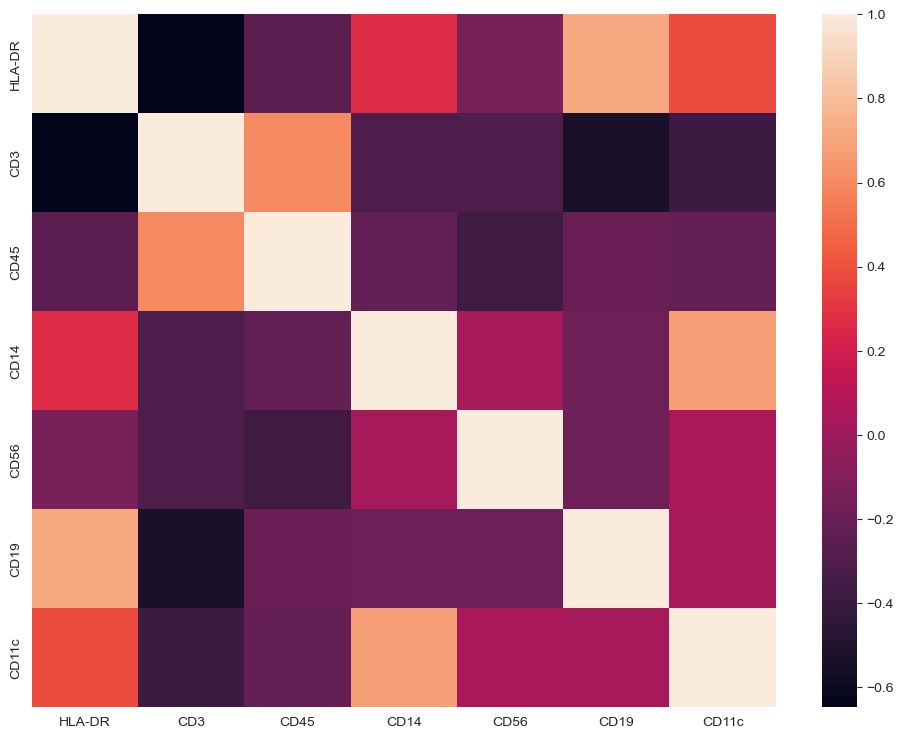

In [23]:
corr_matrix = fc_data_filtered.drop(['FSC-A', 'SSC-A'], axis=1).corr()
sns.heatmap(corr_matrix)

Нормализуем данные:

In [24]:
scaler = StandardScaler()
scaler.fit(fc_data_filtered.drop(['FSC-A', 'SSC-A'], axis=1))
fc_data_filtered_st = scaler.transform(fc_data_filtered.drop(['FSC-A', 'SSC-A'], axis=1))

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [25]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

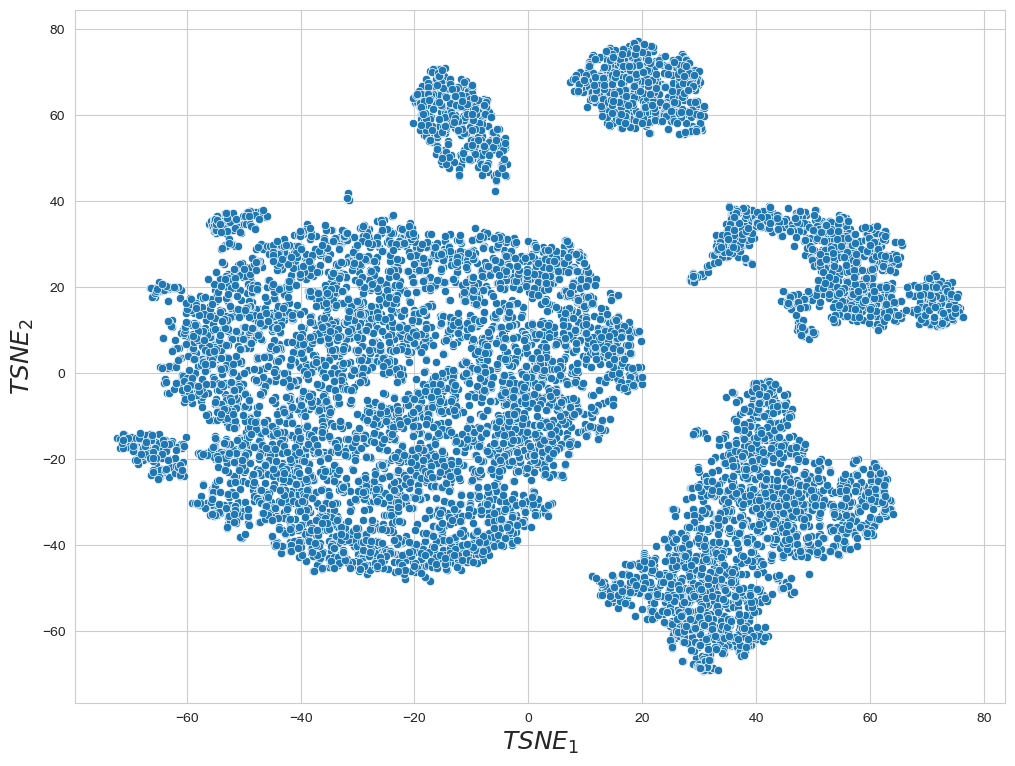

In [26]:
tsne_res = plot_tsne(fc_data_filtered_st)

Ура, я почти угадала количество кластеров!

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

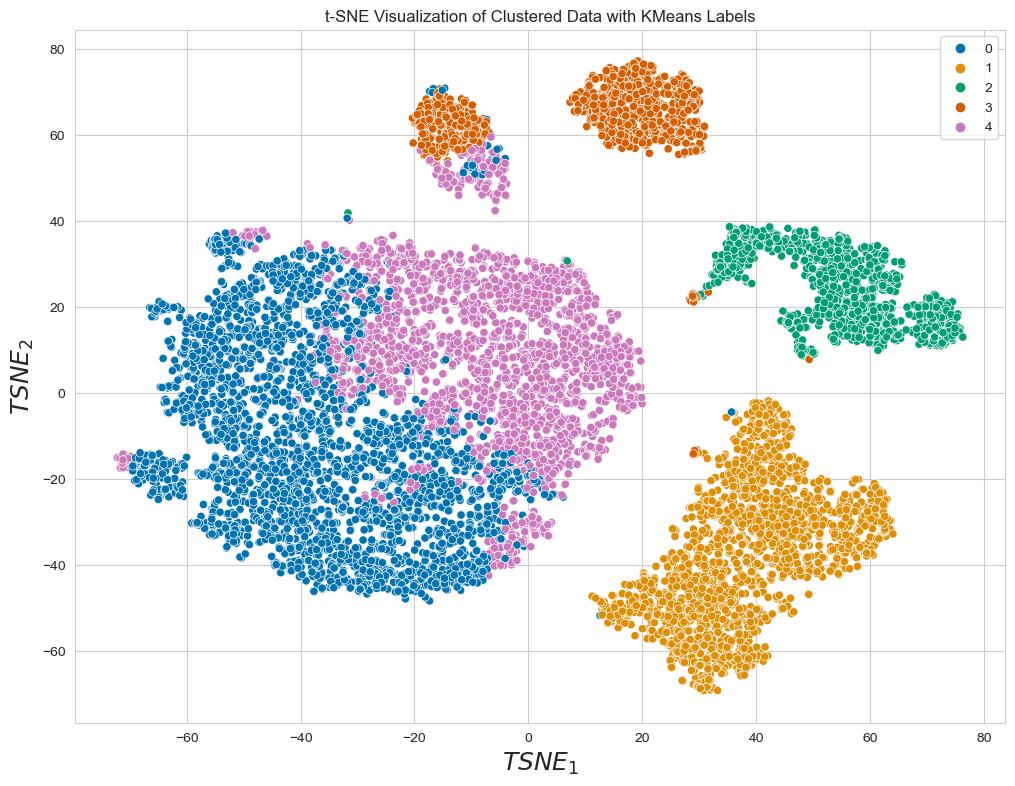

Silhouette Score: 0.299


In [27]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(fc_data_filtered_st)
y_kmeans = kmeans.predict(fc_data_filtered_st)

plot_tsne(fc_data_filtered_st, color=y_kmeans)
plt.title('t-SNE Visualization of Clustered Data with KMeans Labels')
plt.show()

silhouette_avg = silhouette_score(fc_data_filtered_st, y_kmeans)

print(f"Silhouette Score: {silhouette_avg:.3f}")

Отдельные группы красятся в разные цвета, попробуем изменить количество кластеров до 4:

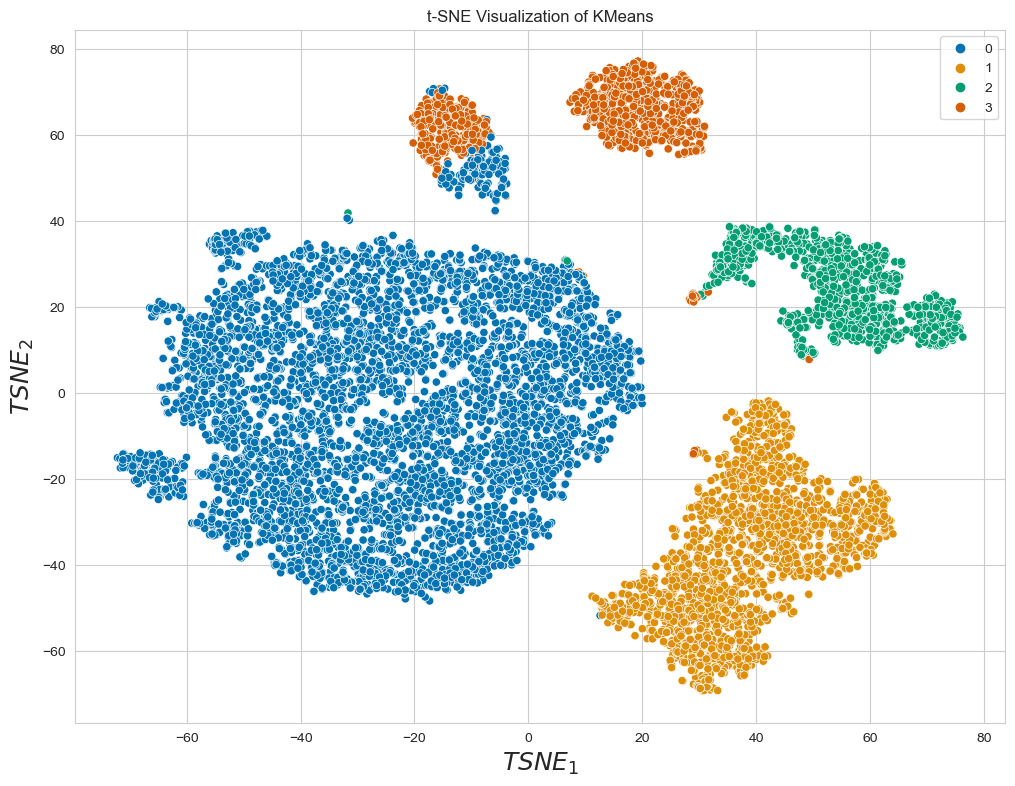

Silhouette Score: 0.567


In [28]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(fc_data_filtered_st)
y_kmeans = kmeans.predict(fc_data_filtered_st)

plot_tsne(fc_data_filtered_st, color=y_kmeans)
plt.title('t-SNE Visualization of KMeans')
plt.show()

silhouette_avg = silhouette_score(fc_data_filtered_st, y_kmeans)

print(f"Silhouette Score: {silhouette_avg:.3f}")

Как-то совсем плохо с kmeans, хоть метрика и стала лучше, визуально - плоховато.
Попробуем иерархическую кластеризацию.

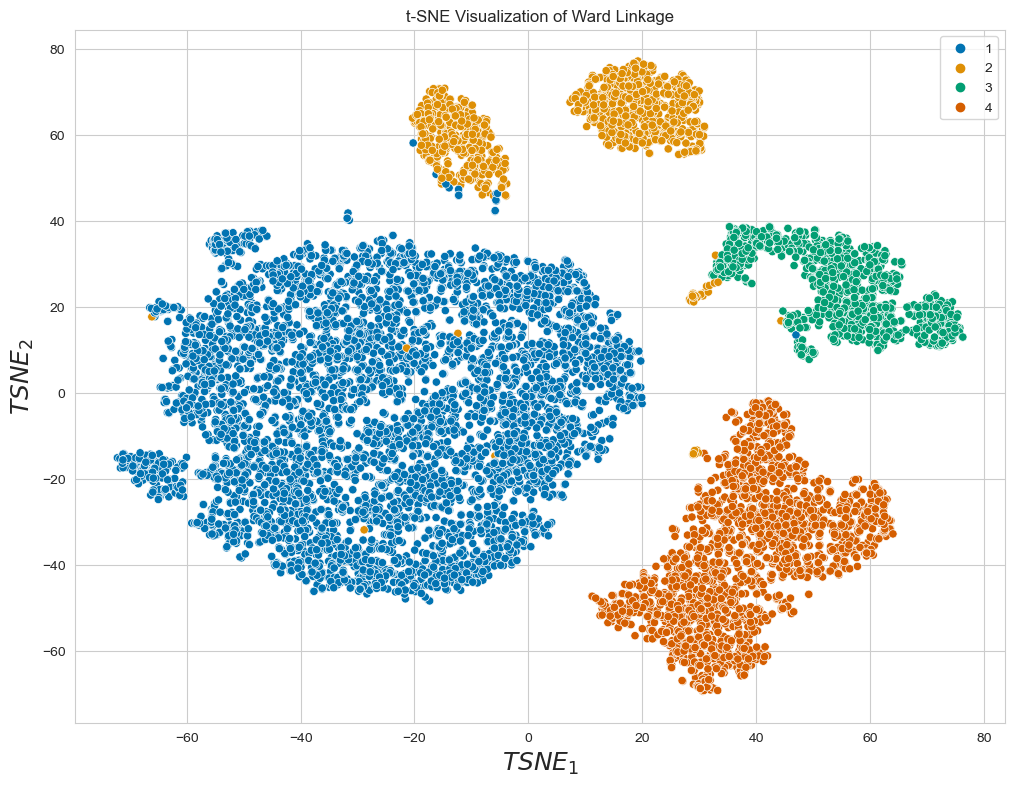

Silhouette Score:  0.5489544874621789


In [29]:
X_link = linkage(fc_data_filtered_st, 'ward')

cluster_labels = fcluster(X_link, criterion='maxclust', t=4)

plot_tsne(fc_data_filtered_st, color=cluster_labels)
plt.title('t-SNE Visualization of Ward Linkage')
plt.show()

score = silhouette_score(fc_data_filtered_st, cluster_labels)
print("Silhouette Score: ", score)

Попробуем 5 кластеров:

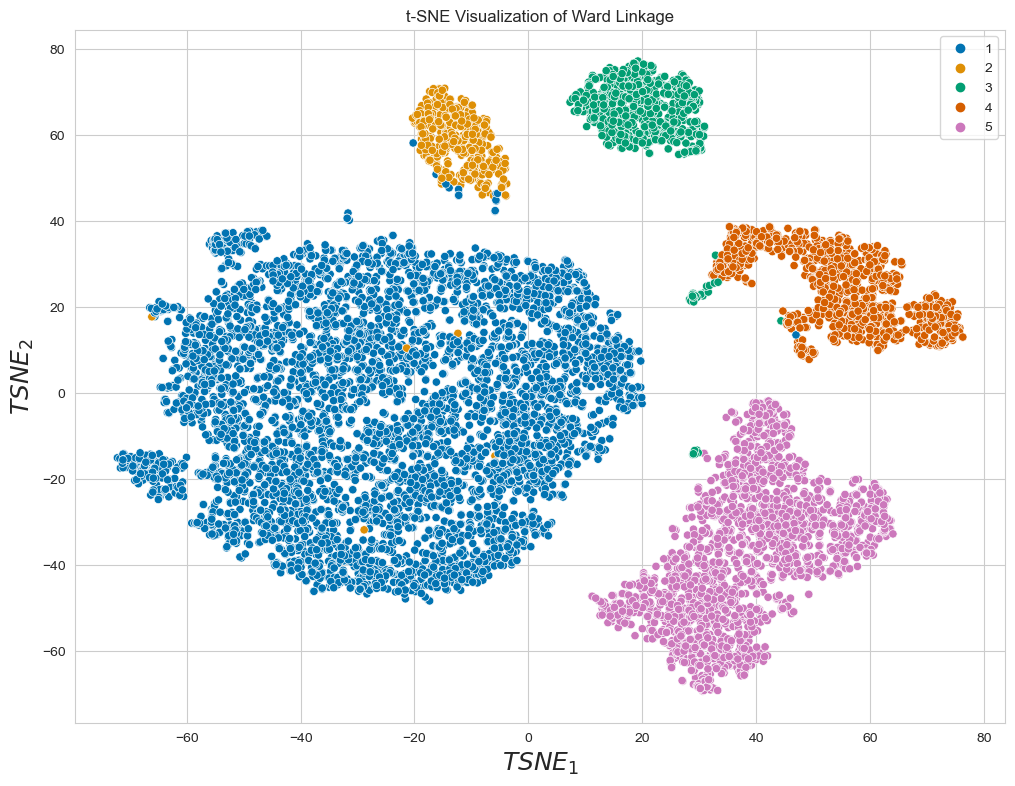

Silhouette Score:  0.47909750971046183


In [30]:
X_link = linkage(fc_data_filtered_st, 'ward')

cluster_labels = fcluster(X_link, criterion='maxclust', t=5)

plot_tsne(fc_data_filtered_st, color=cluster_labels)
plt.title('t-SNE Visualization of Ward Linkage')
plt.show()

score = silhouette_score(fc_data_filtered_st, cluster_labels)
print("Silhouette Score: ", score)

Попробуем DBscan

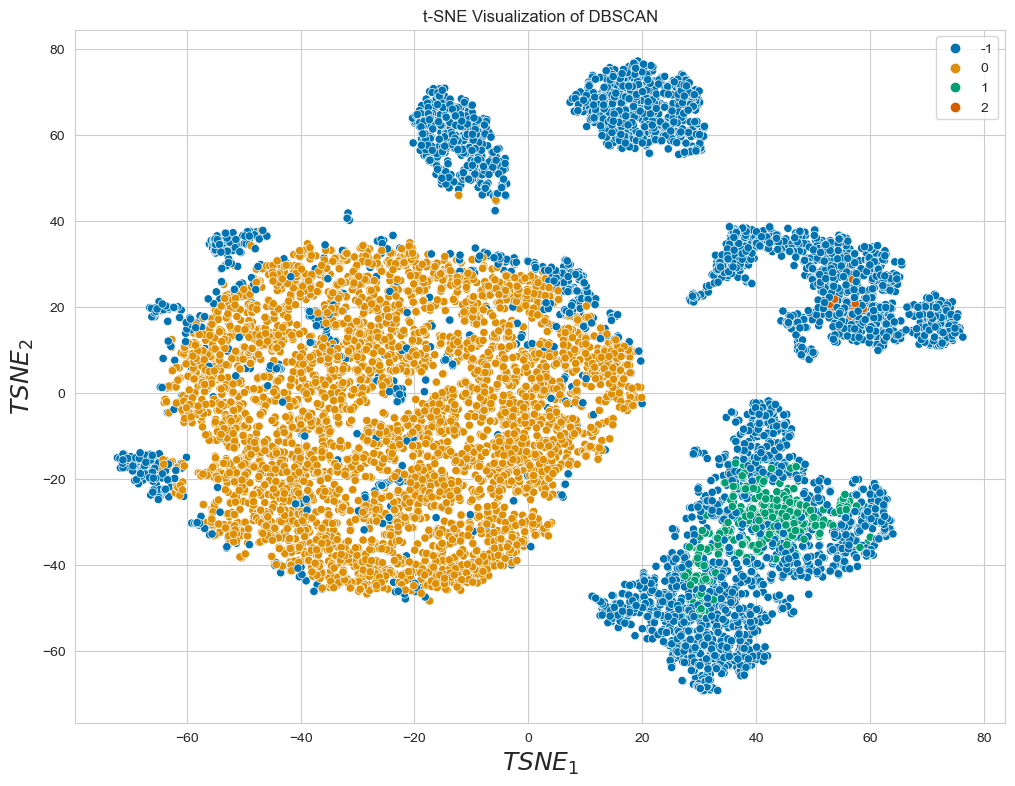

Silhouette Score:  0.16042402255453314


In [31]:
dbscan = DBSCAN(eps=0.5, min_samples=20)
cluster_labels = dbscan.fit_predict(fc_data_filtered_st)

plot_tsne(fc_data_filtered_st, color=cluster_labels)
plt.title('t-SNE Visualization of DBSCAN')
plt.show()

score = silhouette_score(fc_data_filtered_st, cluster_labels)
print("Silhouette Score: ", score)

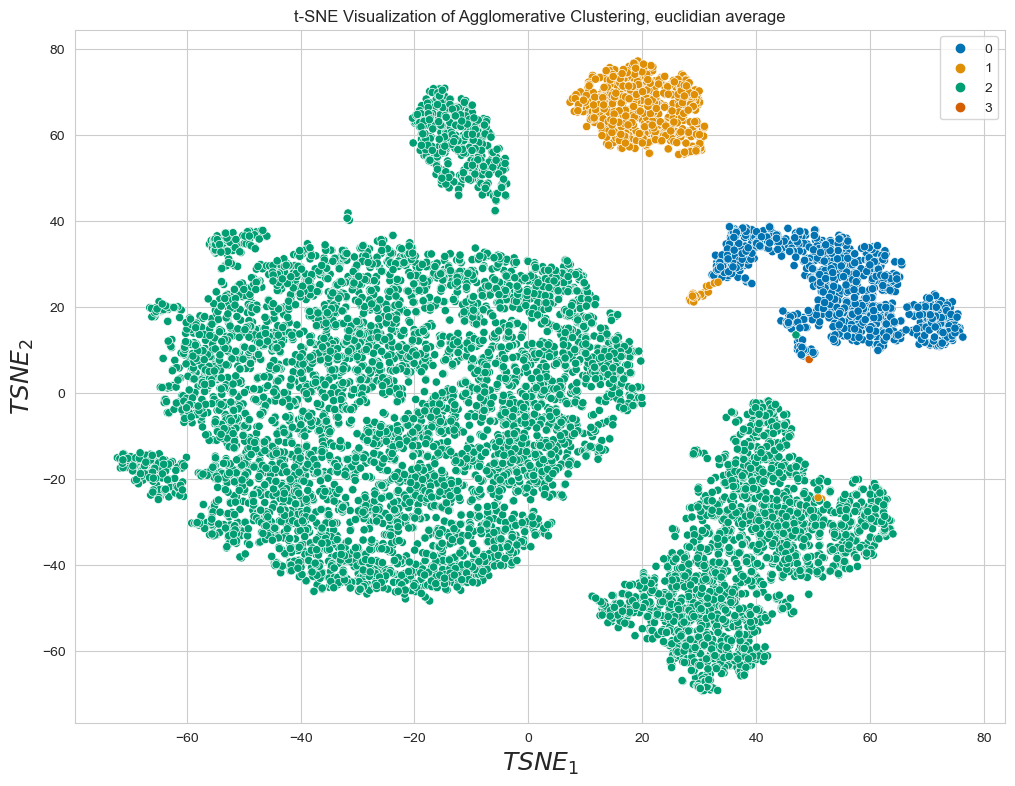

Silhouette Score:  0.4338624334385017


In [32]:
agg_clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
cluster_labels = agg_clustering.fit_predict(fc_data_filtered_st)

plot_tsne(fc_data_filtered_st, color=cluster_labels)
plt.title('t-SNE Visualization of Agglomerative Clustering, euclidian average')
plt.show()

score = silhouette_score(fc_data_filtered_st, cluster_labels)
print("Silhouette Score: ", score)

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Ну почти. Лучше всего сработал ward.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

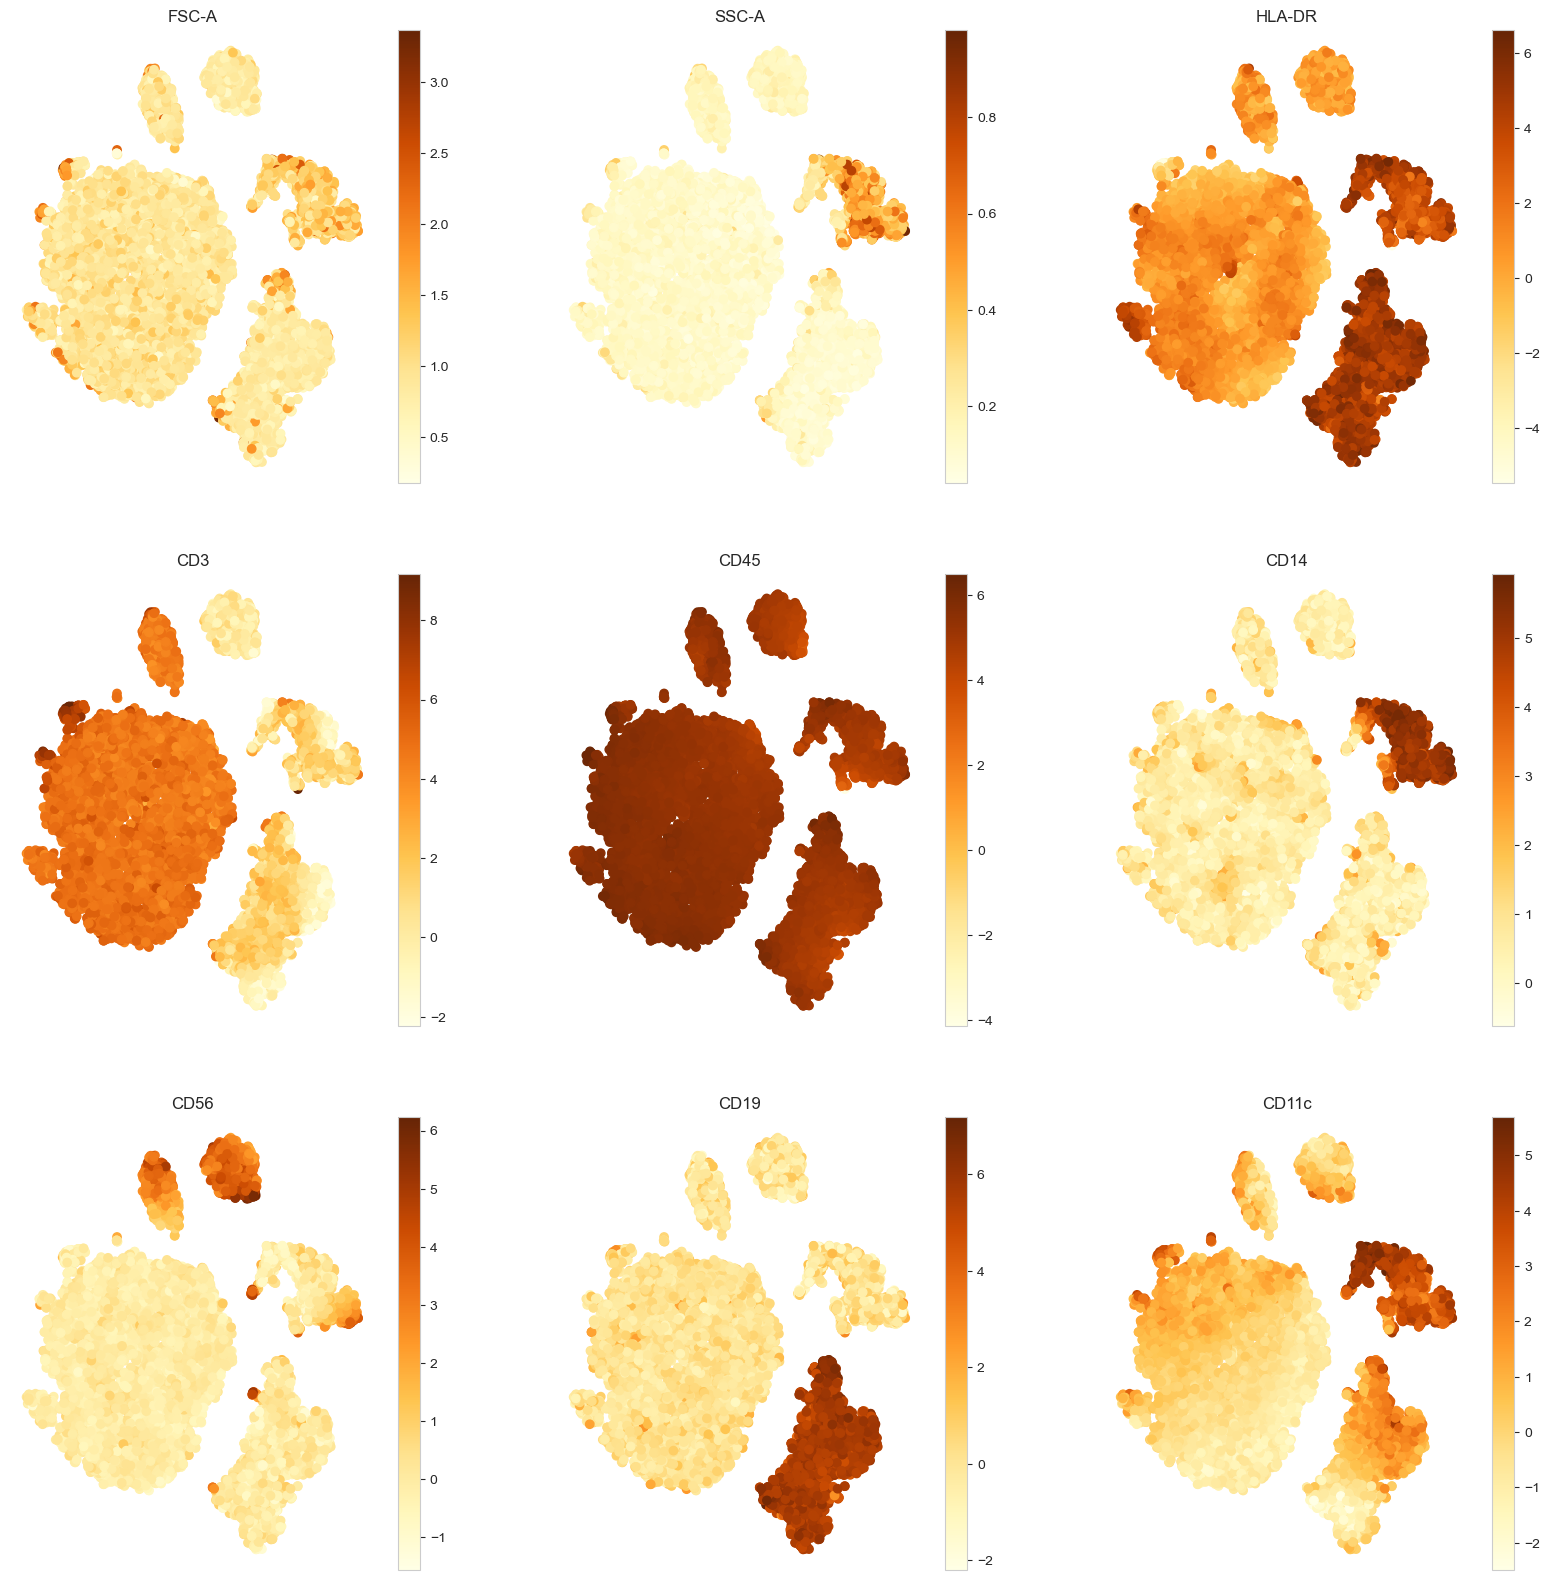

In [33]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_filtered.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_filtered[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [34]:
cell_type_cluster_map = {0: "Other cells", 
                         1: "Monocytes", 
                         2: "T-cells", 
                         3: "B-cells"}

In [35]:
X_link = linkage(fc_data_filtered_st, 'ward')

cluster_labels = fcluster(X_link, criterion='maxclust', t=4)

In [36]:
labeled_fc_data = fc_data_filtered.assign(Population=cluster_labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)
labeled_fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c Population  
0    -1.406912  0.384406    T-cells  
1     6.034845  0.577039        NaN  
2    -0.318668 -0.493832  Monocytes  
3     0.694883  3.416960  Monocytes  
4     5.563345  0.471591        NaN  
...        ...       ...        ...  
9995 -0.591343  2.857737    B-cells  
9996  0.344169 -0.626795  Monocytes  
9997 -0.887078  4.369294    B-cells  
9998 -0.112999  0.069239    T-cells  
9999 -0.441455  0.378331    T-cells  

[9964 rows x 10 columns]

In [45]:
labeled_fc_data.Population.unique()

array(['T-cells', nan, 'Monocytes', 'B-cells'], dtype=object)

Посчитайте, как распределены типы клеток:

<Axes: xlabel='Population', ylabel='Count'>

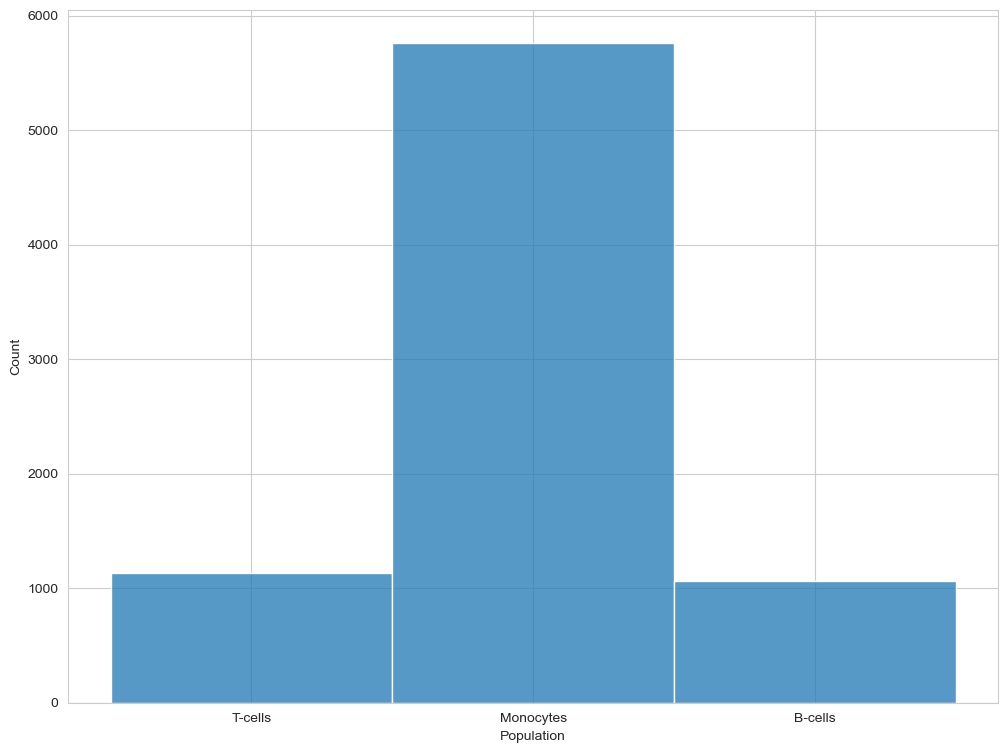

In [41]:
sns.histplot(data=labeled_fc_data, x='Population')

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [46]:
labeled_fc_data.to_csv('result.csv', index=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**